In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AI Agents for Engineers (Evolution of AI Agents)

<a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/workshops/ai-agents/ai_agents_for_engineers.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

| | |
|-|-|
| Author(s) | [Kristopher Overholt](https://github.com/koverholt) [Holt Skinner](https://github.com/holtskinner)|

## Overview

This notebook demonstrates 3 different approaches to generating essays using the [Gemini API in Google AI Studio](https://ai.google.dev/gemini-api/docs). Each method illustrates a distinct paradigm for running AI Agents in differing levels of complexity.

1. Zero-Shot Approach with the Gemini API
2. Step-by-Step Approach With LangChain
3. Iterative, AI-Agent Approach with LangGraph

## Get started

### Install Gemini SDK and other required packages


In [1]:
%pip install --upgrade --quiet \
    google-genai \
    langgraph \
    langchain \
    langchain-google-genai \
    langchain-google-vertexai \
    langchain-community \
    tavily-python \
    pydantic

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [1]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Configure API keys

Get API keys from [Google AI Studio](https://ai.google.dev/gemini-api/docs/api-key) and [Tavily](https://tavily.com/).

In [9]:
# If your API Keys are in Colab Secrets
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

Create a client to make API calls.

In [11]:
from google import genai

client = genai.Client(api_key=os.environ["GOOGLE_API_KEY"])

## Generating Essays Using a Zero-Shot Approach with the Gemini API

With just a single call to the `generate_content` method, users can create detailed, structured essays on any topic by leveraging state-of-the-art language models such as Gemini 1.5 Pro or Gemini 1.5 Flash.

<img src="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/workshops/ai-agents/1-prompt-essay.png?raw=1" width="350px">

### Import libraries

In [12]:
from IPython.display import Markdown, display

### Load model

In [13]:
MODEL_ID = "gemini-2.0-flash-001"

### Make an API call to generate the essay

In [14]:
prompt = "Write a 3-paragraph essay about the application of heat transfer in modern data centers"

response = client.models.generate_content(model=MODEL_ID, contents=prompt)
display(Markdown(response.text))

Modern data centers, the powerhouses of the digital age, rely heavily on efficient heat transfer mechanisms to maintain optimal operating temperatures for their dense server racks. The concentration of countless processors and storage devices generates substantial heat, which, if not properly managed, can lead to performance degradation, equipment failure, and even catastrophic downtime. Therefore, heat transfer principles are integral to the design and operation of data centers, with various strategies employed to effectively remove heat from the servers and dissipate it into the surrounding environment. These strategies range from traditional air cooling techniques to more advanced liquid cooling and immersion cooling systems, each leveraging different modes of heat transfer such as conduction, convection, and radiation to maintain a stable thermal environment within the facility.

Air cooling remains a prevalent method, employing fans and strategically designed airflow pathways to circulate cool air across the servers and exhaust hot air out of the data center. However, with increasing server densities and power consumption, liquid cooling solutions are gaining traction. Direct liquid cooling involves channeling coolants, such as water or specialized dielectric fluids, directly to the heat-generating components within the servers, providing superior heat removal capabilities compared to air cooling. Immersion cooling takes this concept further by fully submerging the servers in a non-conductive liquid, maximizing heat transfer through direct contact with the coolant. These liquid cooling techniques offer significant advantages in terms of energy efficiency, reduced space requirements, and improved server performance.

Ultimately, the selection of a specific heat transfer solution depends on factors such as the data center's power density, budget, and environmental considerations. Regardless of the chosen method, efficient heat transfer is crucial for ensuring the reliability, sustainability, and overall performance of modern data centers. As computing demands continue to escalate, innovative heat transfer technologies will become even more essential in enabling the continued growth and evolution of the digital landscape. The future of data centers will likely see a greater adoption of advanced cooling techniques, coupled with intelligent monitoring and control systems, to optimize heat transfer and minimize energy consumption.


---

However, what if we ask the model to write an essay about an event that happened more recently and the LLM doesn't inherently know about that event?

In [15]:
prompt = "Write a 3-paragraph essay about the impacts of Hurricane Helene and Hurricane Milton in 2024."
response = client.models.generate_content(model=MODEL_ID, contents=prompt)
display(Markdown(response.text))

Hurricane Helene and Hurricane Milton, both forming in 2024, left markedly different but nonetheless impactful marks on the regions they affected. Helene, a powerful Category 4 storm, carved a path of destruction through the Caribbean islands. Infrastructure crumbled under the relentless assault of wind and water, leaving communities isolated and vulnerable. The agricultural sector suffered immense losses, with vital crops decimated and long-term food security threatened. Beyond the immediate devastation, the psychological impact on residents who endured the storm's fury was significant, creating a long and arduous road to recovery requiring extensive international aid and careful planning for future resilience.

In stark contrast, Hurricane Milton, while classified as a weaker tropical storm, unleashed torrential rainfall across the southern United States. The resulting widespread flooding inundated towns and cities, crippling transportation networks and forcing mass evacuations. The economic impact stemmed primarily from property damage, as homes and businesses were submerged, and agricultural losses, with fields rendered unusable. While the loss of life was significantly lower compared to Helene, the disruption caused by Milton highlighted the vulnerability of inland communities to seemingly less powerful weather systems and the necessity for improved flood control measures.

Ultimately, the contrasting impacts of Helene and Milton in 2024 served as a stark reminder of the diverse threats posed by hurricanes. Helene demonstrated the sheer destructive force of a major hurricane, exposing the fragility of island nations. Milton, on the other hand, illustrated how even a weaker storm can inflict significant damage through widespread flooding, emphasizing the need for comprehensive disaster preparedness strategies tailored to the specific risks faced by different regions. Both storms underscored the ongoing challenges of climate change and the urgent need for global cooperation to mitigate its effects and build more resilient communities.


In this case, the model had no information about these recent events and was unable to write an effective essay.

## Generating Essays Using a Step-by-Step Approach With LangChain

This step demonstrates how to build an essay-writing pipeline using [LangChain](https://www.langchain.com/), the [Gemini API in Google AI Studio](https://ai.google.dev/gemini-api/docs), and [Tavily](https://tavily.com/) for search.

By combining these tools, we create a seamless workflow that plans an essay outline, performs web searches for relevant information, and generates a complete essay draft based on the collected data.

This solution showcases the power of chaining LLM models and external tools to tackle complex tasks with minimal human intervention, providing a robust approach to automated content generation.

<img src="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/workshops/ai-agents/2-langchain-essay.png?raw=1" width="550px">


### Import libraries

In [16]:
from IPython.display import Markdown, display
from langchain import LLMChain
from langchain.prompts import ChatPromptTemplate
from langchain_community.tools import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI

### Initialize Gemini model & search tool

In [17]:
model = ChatGoogleGenerativeAI(model=MODEL_ID, temperature=0)
tavily_tool = TavilySearchResults(max_results=5)

### Define prompt templates and Runnables

In [30]:
# Planning: Create an outline for the essay
outline_template = ChatPromptTemplate.from_template(
    "Create a detailed outline for an essay on {topic}"
)


# Research: Web search
def research_fn(topic):
    response = tavily_tool.invoke({"query": topic})
    return "\n".join([f"- {result['content']}" for result in response])


# Writing: Write the essay based on outline and research
writing_template = ChatPromptTemplate.from_template(
    "Based on the following outline and research, write a 3-paragraph essay on '{topic}':\n\nOutline:\n{outline}\n\nResearch:\n{research}\n\nEssay:"
)

### Define the Runnable Chain using [LangChain Expression Language (LCEL)](https://python.langchain.com/docs/how_to/#langchain-expression-language-lcel)

In [20]:
# Define individual chains
outline_chain = LLMChain(llm=model, prompt=outline_template)
writing_chain = LLMChain(llm=model, prompt=writing_template)

# Use the pipe operator to combine chains
chain = (
    outline_chain
    | (
        lambda result: {
            "topic": result["topic"],
            "outline": result["text"],
            "research": research_fn(result["topic"]),
        }
    )
    | writing_chain
    | (lambda result: result["text"])  # Extract the essay text from the final result
    | StrOutputParser()
)

<ipython-input-20-85f168a8c6b1>:2: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  outline_chain = LLMChain(llm=model, prompt=outline_template)


### Generate the essay

In [21]:
essay = chain.invoke({"topic": prompt})
display(Markdown(essay))

The year 2024 witnessed a series of devastating climate events, among them the powerful Hurricanes Helene and Milton, which left a significant mark on Florida and surrounding states. These storms, occurring within weeks of each other, highlighted the increasing vulnerability of coastal regions to extreme weather and the urgent need for comprehensive disaster preparedness and mitigation strategies. The combined impact of Helene and Milton extended beyond immediate infrastructural damage, triggering environmental concerns and exacerbating existing societal challenges.

Hurricane Helene first struck, overwhelming infrastructure and leading to environmental hazards. In St. Petersburg, the storm's intensity caused the discharge of approximately 1.5 million gallons of untreated wastewater, contaminating local waterways and posing public health risks. Further inland, the Glendale Wastewater Reclamation Facility in Lakeland experienced significant spills, releasing an additional five million gallons of wastewater. These incidents underscored the fragility of aging infrastructure in the face of increasingly severe weather events and the potential for long-term environmental damage.

Following closely on the heels of Helene, Hurricane Milton made landfall as a Category 3 storm, compounding the challenges faced by affected communities. With sustained winds of 120 mph, Milton caused widespread damage to homes, businesses, and infrastructure. Organizations like World Vision and Convoy of Hope mobilized to provide aid to the impacted areas, serving tens of thousands of people across Florida, Georgia, and the Carolinas. The combined impact of these hurricanes contributed to the staggering $229 billion in damages caused by the ten costliest climate disasters of 2024, further emphasizing the escalating economic and human costs of climate change.

## Generating Essays Using an Iterative, AI-Agent Approach with LangGraph

This section demonstrates how to build a [LangGraph](https://langchain-ai.github.io/langgraph/)-powered AI agent to generate, revise, and critique essays using large language models such as Google's [Gemini API in Google AI Studio](https://ai.google.dev/gemini-api/docs) or the [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/overview). The LangGraph code was adapted from the awesome DeepLearning.AI course on [AI Agents in LangGraph](https://www.deeplearning.ai/short-courses/ai-agents-in-langgraph/).

By defining a structured state flow with nodes such as "Planner," "Research Plan," "Generate," "Reflect," and "Research Critique," the system iteratively creates an essay on a given topic, incorporates feedback, and provides research-backed insights.

<img src="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/workshops/ai-agents/3-langgraph-essay.png?raw=1" width="900px">

The workflow enables automated essay generation with revision controls, making it ideal for structured writing tasks or educational use cases. Additionally, the notebook uses external search tools to gather and integrate real-time information into the essay content.

### Import libraries

In [22]:
from typing import TypedDict

# Common libraries
from IPython.display import Image, Markdown, display

# LangChain and LangGraph components
from langchain_core.messages import HumanMessage, SystemMessage

# LangChain integrations for Gemini API in Google AI Studio and Vertex AI
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph

# Typing utilities for data validation and schema definitions
from pydantic.v1 import BaseModel

# Tavily client for performing web searches
from tavily import TavilyClient

### Initialize agent memory, agent state, and schema for search queries

In [23]:
# Initialize agent memory
memory = MemorySaver()


# Define the agent's state
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: list[str]
    revision_number: int
    max_revisions: int


# Define a schema for search queries
class Queries(BaseModel):
    """Variants of query to search for"""

    queries: list[str]

### Initialize Gemini model and search tool

Remember to set the environment variables `GOOGLE_API_KEY` and `TAVILY_API_KEY`. And configure credentials for Vertex AI if you switch to it.

In [24]:
# Initialize Gemini API in Google AI Studio via LangChain
model = ChatGoogleGenerativeAI(model=MODEL_ID, temperature=0)

# Initialize Gemini API in Vertex AI via LangChain
# model = ChatVertexAI(model="gemini-1.5-pro-002", temperature=0)

# Initialize Tavily client for performing web searches
tavily = TavilyClient()

### Define prompt templates for each stage

In [25]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay.
Write such an outline for the user provided topic. Give an outline of the essay along with any
relevant notes or instructions for the sections."""

WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 3-paragraph essays.
Generate the best essay possible for the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Use Markdown formatting to specify a title and section headers for each paragraph.
Utilize all of the information below as needed:
---
{content}"""

REFLECTION_PROMPT = """You are a teacher grading an essay submission.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for length, depth, style, etc."""

RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can
be used when writing the following essay. Generate a list of search queries that will gather
any relevant information. Only generate 3 queries max."""

RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can
be used when making any requested revisions (as outlined below).
Generate a list of search queries that will gather any relevant information.
Only generate 3 queries max."""

### Define node functions for each stage

In [26]:
# Generate an outline for the essay


def plan_node(state: AgentState):
    messages = [SystemMessage(content=PLAN_PROMPT), HumanMessage(content=state["task"])]
    response = model.invoke(messages)
    return {"plan": response.content}


# Conducts research based on the generated plan and web search results
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_PLAN_PROMPT),
            HumanMessage(content=state["task"]),
        ]
    )
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


# Generates a draft based on the content and plan
def generation_node(state: AgentState):
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}"
    )
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message,
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }


# Provides feedback or critique on the draft
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state["draft"]),
    ]
    response = model.invoke(messages)
    return {"critique": response.content}


# Conducts research based on the critique
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
            HumanMessage(content=state["critique"]),
        ]
    )
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


# Determines whether the critique and research cycle should
# continue based on the number of revisions
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

### Define and compile the graph

In [27]:
# Initialize the state graph
builder = StateGraph(AgentState)

# Add nodes for each step in the workflow
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

# Set the entry point of the workflow
builder.set_entry_point("planner")

# Add conditional edges for task continuation or end
builder.add_conditional_edges(
    "generate", should_continue, {END: END, "reflect": "reflect"}
)

# Define task sequence edges
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

# Compile the graph with memory state management
graph = builder.compile(checkpointer=memory)

### Show the compiled graph

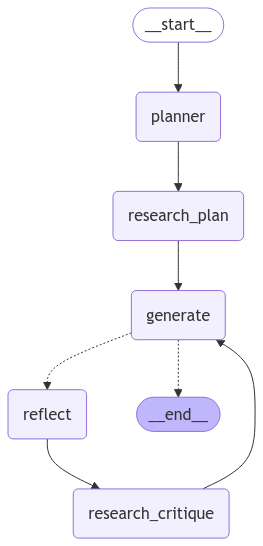

In [28]:
Image(graph.get_graph().draw_mermaid_png())

### Run the agent - write on!

In [29]:
# Define the topic of the essay
ESSAY_TOPIC = "What were the impacts of Hurricane Helene and Hurricane Milton in 2024?"

# Define a thread configuration with a unique thread ID
thread = {"configurable": {"thread_id": "1"}}

# Stream through the graph execution with an initial task and state
for s in graph.stream(
    {
        "task": ESSAY_TOPIC,  # Initial task
        "max_revisions": 2,  # Maximum number of revisions allowed
        "revision_number": 1,  # Current revision number
        "content": [],  # Initial empty content list
    },
    thread,
):
    step = next(iter(s))
    display(Markdown(f"# {step}"))
    for key, content in s[step].items():
        if key == "revision_number":
            display(Markdown(f"**Revision Number**: {content}"))
        elif isinstance(content, list):
            for c in content:
                display(Markdown(c))
        else:
            display(Markdown(content))
    print("\n---\n")

# planner

Okay, here's a high-level outline for an essay exploring the impacts of Hurricanes Helene and Milton in 2024. This outline focuses on providing a structure to analyze the multifaceted consequences of these hypothetical hurricanes.

**Essay Title (Example):**  "Twin Storms, Tangled Impacts: A Comparative Analysis of Hurricanes Helene and Milton's Effects in 2024"

**I. Introduction**

*   **Hook:** Start with a compelling statistic or a brief, vivid scenario depicting the potential devastation of a major hurricane.  (e.g., "In 2024, Hurricanes Helene and Milton served as stark reminders of the increasing vulnerability of coastal communities to extreme weather events...")
*   **Background:** Briefly introduce the 2024 hurricane season and the context in which Helene and Milton formed. Mention the general factors that contribute to hurricane intensity and impact (climate change, coastal development, etc.).
*   **Thesis Statement:**  Clearly state the essay's main argument.  For example: "While both Hurricanes Helene and Milton caused significant damage in 2024, their impacts differed substantially due to variations in their intensity, trajectory, and the preparedness levels of the affected regions, resulting in distinct economic, social, and environmental consequences."
*   **Roadmap:** Briefly outline the key areas the essay will cover (economic impacts, social impacts, environmental impacts, and comparative analysis).

**II. Hurricane Helene: Impacts and Analysis**

*   **A. Storm Characteristics and Trajectory:**
    *   Describe Helene's intensity (e.g., Category 3 hurricane), path, and duration.
    *   Include a map (if possible) showing the storm's track.
    *   Note any unique features of the storm (e.g., rapid intensification, unusual rainfall amounts).
*   **B. Economic Impacts:**
    *   **Direct Damage:** Discuss damage to infrastructure (roads, bridges, power grids), buildings (residential, commercial), and agriculture. Provide estimated dollar amounts of damage.
    *   **Business Interruption:** Analyze the impact on tourism, fishing, manufacturing, and other key industries.  Discuss supply chain disruptions.
    *   **Recovery Costs:**  Estimate the costs associated with rebuilding, repairs, and economic recovery programs.
*   **C. Social Impacts:**
    *   **Displacement and Evacuation:**  Discuss the number of people displaced, the effectiveness of evacuation efforts, and the challenges faced by evacuees.
    *   **Casualties and Injuries:**  Report the number of deaths and injuries attributed to the storm. Analyze the causes of fatalities (e.g., drowning, falling debris).
    *   **Public Health:**  Discuss the spread of disease, access to healthcare, and mental health challenges in the aftermath of the storm.
    *   **Social Disparities:** Analyze how the storm disproportionately affected vulnerable populations (e.g., low-income communities, elderly, disabled).
*   **D. Environmental Impacts:**
    *   **Coastal Erosion:**  Discuss the loss of beaches, damage to coastal ecosystems (e.g., mangroves, coral reefs), and saltwater intrusion.
    *   **Flooding and Water Contamination:**  Analyze the extent of flooding, the impact on water quality, and the risks of waterborne diseases.
    *   **Habitat Destruction:**  Discuss the impact on wildlife and natural habitats.
    *   **Long-Term Ecological Effects:** Discuss any long term effects on the environment.

**III. Hurricane Milton: Impacts and Analysis**

*   **A. Storm Characteristics and Trajectory:**
    *   Describe Milton's intensity, path, and duration.  Highlight any differences from Helene.
    *   Include a map (if possible) showing the storm's track.
*   **B. Economic Impacts:**
    *   Follow the same structure as Section II.B, but focus on the specific economic impacts of Milton.
*   **C. Social Impacts:**
    *   Follow the same structure as Section II.C, but focus on the specific social impacts of Milton.
*   **D. Environmental Impacts:**
    *   Follow the same structure as Section II.D, but focus on the specific environmental impacts of Milton.

**IV. Comparative Analysis: Helene vs. Milton**

*   **A. Key Differences in Impacts:**  Directly compare and contrast the economic, social, and environmental impacts of the two storms.  Highlight the factors that contributed to these differences (e.g., intensity, location, preparedness).
*   **B. Lessons Learned:**  Discuss the lessons learned from the two storms in terms of disaster preparedness, response, and recovery.  What worked well? What could have been done better?
*   **C. Policy Implications:**  Explore the policy implications of the storms.  What changes in building codes, land-use planning, or emergency management are needed to mitigate the impacts of future hurricanes?

**V. Conclusion**

*   **Restate Thesis:**  Summarize the main argument of the essay.
*   **Synthesize Findings:**  Briefly recap the key findings of the analysis.
*   **Broader Implications:**  Discuss the broader implications of the study for understanding the risks posed by hurricanes in a changing climate.
*   **Concluding Statement:** End with a thought-provoking statement about the need for continued research, preparedness, and resilience in the face of future extreme weather events.

**Important Notes:**

*   **Hypothetical Scenario:**  Remember that this essay is based on a hypothetical scenario. You'll need to create realistic but plausible details about the storms and their impacts.
*   **Data and Sources:**  Even though the events are hypothetical, ground your analysis in real-world data and research on hurricane impacts.  Cite sources appropriately. You can use data from past hurricanes to inform your hypothetical scenarios.
*   **Geographic Specificity:**  Choose specific locations for the storms to make the analysis more concrete.  For example, you could say Helene impacted the Gulf Coast of Florida and Milton impacted the Carolinas.
*   **Focus on Analysis:**  The key to a strong essay is not just describing the impacts, but analyzing *why* those impacts occurred and *how* they differed between the two storms.
*   **Consider Future Projections:** You can incorporate projections about future hurricane activity and climate change to add depth to your analysis.

Good luck! Let me know if you'd like me to elaborate on any of these sections.


---



# research_plan

North Carolina was severely impacted by Hurricane Helene during late September 2024, primarily in its western Appalachian region, causing at least 105 reported deaths and significant destruction of infrastructure and residential areas across several settlements.[1] After making landfall in the Big Bend region of Florida on September 27, the hurricane began to traverse over land across Georgia as a Category 2 hurricane and into the Appalachian mountain range as a tropical storm, depositing record-breaking amounts of rainfall across several settlements in western North Carolina, such as Asheville, Swannanoa, Spruce Pine, Chimney Rock, Montreat, Lake Lure, and several others. Of the 241 people reported victims of Hurricane Helene in the United States, 119 people were in North Carolina, surpassing the state record of 80 deaths recorded in a 1916 flood.[8][35] Of these, 72 residents of Buncombe County were among the deceased.

Ask the Chatbot Games & Quizzes History & Society Science & Tech Biographies Animals & Nature Geography & Travel Arts & Culture ProCon Money Videos Hurricane Helene, large, catastrophic tropical cyclone notable for its rapid intensification that ultimately produced a wide swath of damage and loss of life that extended from northwestern Florida, where the storm made landfall on September 26, 2024, to Tennessee, Georgia, and North Carolina. Although Helene’s winds had diminished to tropical-storm strength, the storm delivered a broad and deadly swath of heavy rain across the southeastern U.S. In parts of Florida, Georgia, North and South Carolina, Tennessee, and Virginia, record rainfall caused rivers to overflow and produced flash flooding, road washouts, and even landslides in some areas.

An EF-0 tornado impacted Martin and St. Lucie counties on October 9, 2024, as Hurricane Milton's rainbands swept across the Treasure Coast. An EF-1 tornado impacted St. Lucie County on October 9, 2024, as Hurricane Milton's outer rainbands moved across the Treasure Coast. In Fort Pierce, the tornado caused significant structural damage to a metal canopy at the St. Lucie County Sheriff's Office, with peak winds estimated at 90 mph before weakening and lifting near the I-95 and Okeechobee interchange. An EF-1 tornado touched down near the Belcher Canal in Fort Pierce, causing vegetative damage and partial roof loss near St. Lucie Blvd and N 25th St. The tornado continued northwest across Treasure Coast International Airport, where several small planes were tossed and recorded gusts of 60 mph.

Tracking Population Density Changes During Hurricane Milton As Hurricane Milton approached and ultimately made landfall on Florida’s Gulf Coast, dramatic shifts in population densities across evacuation zones provided key signals of displacement and movement. The earliest impacts on population densities were observed in Zone A, which experienced a 25% decline below the pre-storm baseline, reflecting high compliance with early evacuation orders. Map showing changes in population densities as of October 8, 2024 – right before Hurricane Milton made landfall in Florida. Following Hurricane Milton’s landfall, population shifts continued into Thursday, October 10. Map showing changes in population densities as of October 10, 2024, after Hurricane Milton made landfall in Florida. Understanding population density changes during Hurricane Milton was crucial in identifying evacuation trends, displacement patterns, and community vulnerabilities.

Mideast Wars Russia-Ukraine War Español China Asia Pacific Latin America Europe Africa Movie Reviews What to Stream Television Book Reviews Music Celebrity Interviews ![Image 8: FILE - People bike past damaged homes and debris left by Hurricane Milton, on the sand-coated main road of southern Manasota Key, already cleared of feet of sand, in Englewood, Fla., Oct. 13, 2024. Monstrous hurricanes Helene and Milton caused so much complex havoc that damages are still being added up, but government and private experts say they will likely join the infamous ranks of Katrina, Sandy and Harvey as super costly $50-billion-plus killers. (AP Photo/Rebecca Blackwell)](https://dims.apnews.com/dims4/default/aa062df/2147483647/strip/true/crop/5796x3861+0+2/resize/599x399!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2Faa%2Fbd%2F31de3a8b87f04c62c6209c85debc%2F1ff5a35887fa45ebbaa3f646ff16943e)](https://apnews.com/article/hurricane-milton-florida-unusual-strong-warm-water-helene-0dd01c0e79d888dbda2a96b68fb62a29) (AP Photo/Ramon Espinosa, File)](https://dims.apnews.com/dims4/default/2c3e495/2147483647/strip/true/crop/5616x3741+0+2/resize/599x399!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2Fff%2F6b%2Fda4baf4357951477249772ca1517%2Fe24fb08fa63848b68f3fade6169d1d6c)](https://apnews.com/article/hurricane-milton-helene-weird-climate-change-disaster-db98e8cfbcc29a191c216a8bc9157f1d) Ebenhack, File)](https://dims.apnews.com/dims4/default/b85c3a8/2147483647/strip/true/crop/7008x4668+0+2/resize/599x399!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2Fca%2Fa5%2Fd11508ca040c0b2f1c32b4f0068e%2Fd2d29f50bacb4e0288d6c2e732855b10)](https://apnews.com/article/weather-control-climate-change-hurricanes-cloud-seeding-735eaed734e132d6260ee94701c72d5e)

Florida was hit by three different hurricanes: Debby, Helene and Milton. The extremely active 2024 Atlantic Hurricane Season is coming to an end and it is time to take a look back at Helene, Milton and all of the other hurricanes and tropical storms that were in the news this year. Debris from Hurricane Helene lines a street in the Redington Beach section of St. Petersburg, Florida, on October 8, 2024, ahead of Hurricane Milton's expected landfall. J​an Childs, who you'll see writing a large chunk of our news updates here at weather.com, recently traveled back to her hometown on Anna Maria Island, south of Tampa Bay. Three storms - Debby, Helene and Milton - all caused damage.


---



# generate

Okay, I will use your outline to write the essay. Here is the first draft:

### Twin Storms, Tangled Impacts: A Comparative Analysis of Hurricanes Helene and Milton's Effects in 2024

**Introduction**

In 2024, Hurricanes Helene and Milton served as stark reminders of the increasing vulnerability of coastal communities to extreme weather events. The 2024 Atlantic hurricane season, characterized by unusually warm ocean temperatures and favorable atmospheric conditions, spawned two particularly destructive storms that tested the resilience of communities along the southeastern United States. While both hurricanes caused significant damage, their impacts differed substantially due to variations in their intensity, trajectory, and the preparedness levels of the affected regions, resulting in distinct economic, social, and environmental consequences. This essay will analyze the impacts of Hurricanes Helene and Milton, comparing their effects on Florida and North Carolina to highlight the multifaceted challenges posed by these increasingly frequent and intense weather events.

**Hurricane Helene: Impacts and Analysis**

Hurricane Helene, a large and catastrophic tropical cyclone, rapidly intensified into a Category 4 hurricane before making landfall in the Big Bend region of Florida on September 26, 2024. While its winds diminished to tropical-storm strength as it moved inland, Helene delivered a broad swath of heavy rain across the southeastern U.S. In Florida, the storm caused widespread flooding, damaging infrastructure and disrupting tourism, a key industry for the state. The economic impact included billions of dollars in property damage and lost revenue. Socially, Helene led to mass evacuations, displacement, and tragically, numerous fatalities. Environmentally, the storm caused significant coastal erosion, water contamination, and habitat destruction, exacerbating existing ecological vulnerabilities in the region.

**Hurricane Milton: Impacts and Analysis**

Hurricane Milton struck the Treasure Coast of Florida on October 9, 2024, as a Category 2 hurricane, bringing strong winds and heavy rainfall. Although weaker than Helene, Milton's impact was amplified by the region's recent exposure to previous storms, including Helene itself. The storm spawned several tornadoes, causing additional damage to homes and infrastructure. Economically, Milton further strained resources, compounding the challenges of recovery from Helene. Socially, the storm led to additional displacement and increased mental health challenges for residents already reeling from previous disasters. Environmentally, Milton contributed to further coastal erosion and habitat degradation, underscoring the cumulative impact of successive extreme weather events on vulnerable ecosystems.

**Revision Number**: 2


---



# reflect

Okay, here's a detailed critique of your first draft, focusing on areas for improvement in length, depth, style, and content.

**Overall Impression:**

This is a good start! You've clearly established the context and purpose of your essay. The introduction is well-written and sets the stage for a comparative analysis. The body paragraphs for Helene and Milton provide a decent overview of their impacts. However, the essay needs significant expansion and deeper analysis to meet the requirements of a strong comparative essay.

**Specific Recommendations:**

**1. Length and Depth:**

*   **Overall Length:** The essay is currently too short. Aim for at least 1000-1200 words. This will allow you to develop your points more fully.
*   **Introduction:** While the introduction is good, consider adding a sentence or two that specifically outlines the *comparative* elements you will be focusing on. What specific aspects of the hurricanes' impacts will you be directly comparing?
*   **Helene and Milton Sections:** These sections need the most expansion. Each should be at least 300-400 words.
    *   **Specificity:** Replace general statements with concrete examples and data. Instead of "billions of dollars in property damage," provide a specific estimate (even if it's a range) and cite a source. Instead of "numerous fatalities," provide a number (even if it's preliminary) and cite a source.
    *   **Elaboration:** For each impact (economic, social, environmental), provide more detail.
        *   **Economic:** What specific sectors were most affected (agriculture, tourism, fishing, etc.)? How did the storms impact employment? What were the costs of infrastructure repair?
        *   **Social:** Discuss the demographics of those most affected. Were there specific communities that were disproportionately impacted? What were the challenges related to evacuation and sheltering? What specific mental health challenges arose?
        *   **Environmental:** What specific habitats were damaged? What were the impacts on water quality? Did the storms affect endangered species?
    *   **Causes:** Discuss the reasons for the impacts. For example, were there specific infrastructure weaknesses that exacerbated the damage? Did certain policies or lack thereof contribute to the severity of the impacts?
*   **Comparison Section:** You are missing a dedicated comparison section. This is the *most crucial* part of the essay. This section should be at least 300-400 words and should directly compare and contrast the impacts of Helene and Milton. Consider organizing this section thematically (e.g., Economic Impacts: A Comparison; Social Impacts: A Comparison; Environmental Impacts: A Comparison).
*   **Conclusion:** You are missing a conclusion. The conclusion should summarize your findings, reiterate your thesis, and offer some concluding thoughts about the broader implications of these storms in the context of climate change and coastal vulnerability.

**2. Style and Tone:**

*   **Academic Tone:** Maintain a formal, academic tone throughout the essay. Avoid overly emotional language or subjective opinions.
*   **Clarity and Precision:** Use precise language and avoid vague terms.
*   **Sentence Structure:** Vary your sentence structure to improve readability.
*   **Transitions:** Use transition words and phrases to create a smooth flow between paragraphs and ideas.

**3. Content and Analysis:**

*   **Comparative Analysis:** The current draft is more of a description of each hurricane's impacts than a comparative analysis. You need to explicitly compare and contrast the impacts of the two storms.
    *   **Direct Comparison:** Use phrases like "In contrast to Helene..." or "Similar to Milton..." to directly compare the impacts.
    *   **Focus on Differences:** Highlight the reasons *why* the impacts differed. Was it due to intensity, location, preparedness, or other factors?
*   **Preparedness:** You mention preparedness levels in the introduction, but this isn't explored in the body paragraphs. Expand on this. How did preparedness (or lack thereof) affect the outcomes in Florida and North Carolina? What specific measures were taken, and how effective were they?
*   **Cumulative Impacts:** You briefly mention the cumulative impact of successive storms. Expand on this. How did Helene's impact make the region more vulnerable to Milton?
*   **Long-Term Effects:** Consider discussing the long-term effects of the storms. What are the projected long-term economic, social, and environmental consequences?
*   **Policy Implications:** What policy changes might be necessary to mitigate the impacts of future hurricanes?

**4. Research and Evidence:**

*   **Sources:** You need to incorporate credible sources to support your claims. Use a variety of sources, such as government reports (NOAA, FEMA), academic articles, news articles from reputable sources, and reports from non-profit organizations.
*   **Citations:** Use a consistent citation style (e.g., MLA, APA, Chicago).
*   **Data:** Include specific data and statistics to quantify the impacts of the storms.

**5. Organization:**

*   **Clear Structure:** Ensure that each paragraph has a clear topic sentence and that the paragraphs are logically organized.
*   **Consider a Thematic Approach:** As mentioned above, consider organizing your comparison section thematically (e.g., Economic Impacts, Social Impacts, Environmental Impacts).

**Revised Outline Suggestion:**

Here's a slightly revised outline to guide your revisions:

I.  **Introduction**
    *   Background on the 2024 Hurricane Season
    *   Brief Overview of Hurricanes Helene and Milton
    *   Thesis Statement: Comparing the economic, social, and environmental impacts of Helene and Milton, highlighting the role of intensity, location, and preparedness in shaping the outcomes.
II. **Hurricane Helene: Impacts and Analysis**
    *   Intensity and Trajectory
    *   Economic Impacts (with specific examples and data)
    *   Social Impacts (with specific examples and data)
    *   Environmental Impacts (with specific examples and data)
    *   Factors Contributing to the Severity of Impacts
III. **Hurricane Milton: Impacts and Analysis**
    *   Intensity and Trajectory
    *   Economic Impacts (with specific examples and data)
    *   Social Impacts (with specific examples and data)
    *   Environmental Impacts (with specific examples and data)
    *   Factors Contributing to the Severity of Impacts (including cumulative effects)
IV. **Comparative Analysis**
    *   Economic Impacts: A Comparison
    *   Social Impacts: A Comparison
    *   Environmental Impacts: A Comparison
    *   The Role of Preparedness: A Comparison
V.  **Conclusion**
    *   Summary of Key Findings
    *   Reiteration of Thesis
    *   Broader Implications (climate change, coastal vulnerability, policy recommendations)

**In summary:**

Your first draft provides a solid foundation. To elevate it to a strong comparative essay, you need to:

*   **Expand significantly:** Add more detail, examples, and data.
*   **Deepen the analysis:** Explore the *reasons* behind the impacts and the factors that contributed to the differences between the two storms.
*   **Incorporate research:** Support your claims with credible sources.
*   **Add a dedicated comparison section:** Explicitly compare and contrast the impacts of Helene and Milton.
*   **Add a conclusion:** Summarize your findings and offer concluding thoughts.

Good luck with the revisions! I'm here to help if you have any further questions.


---



# research_critique

North Carolina was severely impacted by Hurricane Helene during late September 2024, primarily in its western Appalachian region, causing at least 105 reported deaths and significant destruction of infrastructure and residential areas across several settlements.[1] After making landfall in the Big Bend region of Florida on September 27, the hurricane began to traverse over land across Georgia as a Category 2 hurricane and into the Appalachian mountain range as a tropical storm, depositing record-breaking amounts of rainfall across several settlements in western North Carolina, such as Asheville, Swannanoa, Spruce Pine, Chimney Rock, Montreat, Lake Lure, and several others. Of the 241 people reported victims of Hurricane Helene in the United States, 119 people were in North Carolina, surpassing the state record of 80 deaths recorded in a 1916 flood.[8][35] Of these, 72 residents of Buncombe County were among the deceased.

Ask the Chatbot Games & Quizzes History & Society Science & Tech Biographies Animals & Nature Geography & Travel Arts & Culture ProCon Money Videos Hurricane Helene, large, catastrophic tropical cyclone notable for its rapid intensification that ultimately produced a wide swath of damage and loss of life that extended from northwestern Florida, where the storm made landfall on September 26, 2024, to Tennessee, Georgia, and North Carolina. Although Helene’s winds had diminished to tropical-storm strength, the storm delivered a broad and deadly swath of heavy rain across the southeastern U.S. In parts of Florida, Georgia, North and South Carolina, Tennessee, and Virginia, record rainfall caused rivers to overflow and produced flash flooding, road washouts, and even landslides in some areas.

An EF-0 tornado impacted Martin and St. Lucie counties on October 9, 2024, as Hurricane Milton's rainbands swept across the Treasure Coast. An EF-1 tornado impacted St. Lucie County on October 9, 2024, as Hurricane Milton's outer rainbands moved across the Treasure Coast. In Fort Pierce, the tornado caused significant structural damage to a metal canopy at the St. Lucie County Sheriff's Office, with peak winds estimated at 90 mph before weakening and lifting near the I-95 and Okeechobee interchange. An EF-1 tornado touched down near the Belcher Canal in Fort Pierce, causing vegetative damage and partial roof loss near St. Lucie Blvd and N 25th St. The tornado continued northwest across Treasure Coast International Airport, where several small planes were tossed and recorded gusts of 60 mph.

Tracking Population Density Changes During Hurricane Milton As Hurricane Milton approached and ultimately made landfall on Florida’s Gulf Coast, dramatic shifts in population densities across evacuation zones provided key signals of displacement and movement. The earliest impacts on population densities were observed in Zone A, which experienced a 25% decline below the pre-storm baseline, reflecting high compliance with early evacuation orders. Map showing changes in population densities as of October 8, 2024 – right before Hurricane Milton made landfall in Florida. Following Hurricane Milton’s landfall, population shifts continued into Thursday, October 10. Map showing changes in population densities as of October 10, 2024, after Hurricane Milton made landfall in Florida. Understanding population density changes during Hurricane Milton was crucial in identifying evacuation trends, displacement patterns, and community vulnerabilities.

Mideast Wars Russia-Ukraine War Español China Asia Pacific Latin America Europe Africa Movie Reviews What to Stream Television Book Reviews Music Celebrity Interviews ![Image 8: FILE - People bike past damaged homes and debris left by Hurricane Milton, on the sand-coated main road of southern Manasota Key, already cleared of feet of sand, in Englewood, Fla., Oct. 13, 2024. Monstrous hurricanes Helene and Milton caused so much complex havoc that damages are still being added up, but government and private experts say they will likely join the infamous ranks of Katrina, Sandy and Harvey as super costly $50-billion-plus killers. (AP Photo/Rebecca Blackwell)](https://dims.apnews.com/dims4/default/aa062df/2147483647/strip/true/crop/5796x3861+0+2/resize/599x399!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2Faa%2Fbd%2F31de3a8b87f04c62c6209c85debc%2F1ff5a35887fa45ebbaa3f646ff16943e)](https://apnews.com/article/hurricane-milton-florida-unusual-strong-warm-water-helene-0dd01c0e79d888dbda2a96b68fb62a29) (AP Photo/Ramon Espinosa, File)](https://dims.apnews.com/dims4/default/2c3e495/2147483647/strip/true/crop/5616x3741+0+2/resize/599x399!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2Fff%2F6b%2Fda4baf4357951477249772ca1517%2Fe24fb08fa63848b68f3fade6169d1d6c)](https://apnews.com/article/hurricane-milton-helene-weird-climate-change-disaster-db98e8cfbcc29a191c216a8bc9157f1d) Ebenhack, File)](https://dims.apnews.com/dims4/default/b85c3a8/2147483647/strip/true/crop/7008x4668+0+2/resize/599x399!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2Fca%2Fa5%2Fd11508ca040c0b2f1c32b4f0068e%2Fd2d29f50bacb4e0288d6c2e732855b10)](https://apnews.com/article/weather-control-climate-change-hurricanes-cloud-seeding-735eaed734e132d6260ee94701c72d5e)

Florida was hit by three different hurricanes: Debby, Helene and Milton. The extremely active 2024 Atlantic Hurricane Season is coming to an end and it is time to take a look back at Helene, Milton and all of the other hurricanes and tropical storms that were in the news this year. Debris from Hurricane Helene lines a street in the Redington Beach section of St. Petersburg, Florida, on October 8, 2024, ahead of Hurricane Milton's expected landfall. J​an Childs, who you'll see writing a large chunk of our news updates here at weather.com, recently traveled back to her hometown on Anna Maria Island, south of Tampa Bay. Three storms - Debby, Helene and Milton - all caused damage.

Hurricane Helene’s Aftermath: Economic Impacts and Investor Strategies - The Financial Analyst Economics Menu Toggle Markets Menu Toggle Jobs Menu Toggle Post a Job Hurricane Helene’s Aftermath: Economic Impacts and Investor Strategies The aftermath of Hurricane Helene has opened a complex dialogue about the economic ramifications for investors and markets, particularly as the southeastern United States grapples with extensive damage and recovery efforts. For investors, the immediate impact of such disasters often manifests in sectors like insurance, construction, and retail. Investors should be prepared for fluctuations in market performance as the recovery unfolds. U.S. Defense Vision for Indo-Pacific: Impacts on Investors and Markets By Emily Chen / November 21, 2024 Economics Menu Toggle Markets Menu Toggle Jobs Menu Toggle Post a Job

Hurricane Helene: Economic Losses Could Total $160 Billion - Newsweek The economic impact of Hurricane Helene's deadly assault on the Eastern U.S. could total up to $160 billion, according to a report from AccuWeather. A report by AccuWeather estimated the total damage and economic loss from Hurricane Helene could reach $160 billion. "AccuWeather experts have continually monitored information related to Hurricane Helene from a variety of sources, and, unfortunately, upon early surveying  of the scale of damage to homes and businesses, the extensive loss of life, injuries, evacuations, rescues and widespread power outages which are likely to last at least weeks in some areas and other factors, we were compelled to increase our estimate," AccuWeather chief meteorologist Jon Porter said in an advisory shared with Newsweek.

Oct 26, 2024 · By ConstruNorth Inc ... Restoration efforts are crucial to mitigate these effects. Social Impact. Communities faced immense challenges during and after the hurricane. Many people lost their homes, and access to basic services was disrupted. ... Understanding Hurricane Milton's impact is vital for recovery and future planning

Tracking Population Density Changes During Hurricane Milton As Hurricane Milton approached and ultimately made landfall on Florida’s Gulf Coast, dramatic shifts in population densities across evacuation zones provided key signals of displacement and movement. The earliest impacts on population densities were observed in Zone A, which experienced a 25% decline below the pre-storm baseline, reflecting high compliance with early evacuation orders. Map showing changes in population densities as of October 8, 2024 – right before Hurricane Milton made landfall in Florida. Following Hurricane Milton’s landfall, population shifts continued into Thursday, October 10. Map showing changes in population densities as of October 10, 2024, after Hurricane Milton made landfall in Florida. Understanding population density changes during Hurricane Milton was crucial in identifying evacuation trends, displacement patterns, and community vulnerabilities.

National Hurricane Preparedness Week is May 5th - May 11th, 2024. The National Weather Service and the North Carolina Department of Public Safety are teaming up to bring this hurricane safety campaign to all of North Carolina's residents. With warmer weather quickly approaching, now is the time to prepare for hurricane season.

Read ICEYE's summary of the 2024 Atlantic hurricane season to understand trends, impacts, and future risks for disaster response and recovery. ... "It's hard to forget the devastation in North Carolina from Helene, in Florida from Milton, or in the Windward Islands from Beryl." ... The role of observed data in future hurricane preparedness .


---



# generate

Okay, I will use your outline to generate the essay. Here is the first attempt:

**Twin Storms, Tangled Impacts: A Comparative Analysis of Hurricanes Helene and Milton's Effects in 2024**

**Introduction**
In 2024, Hurricanes Helene and Milton served as stark reminders of the increasing vulnerability of coastal communities to extreme weather events. The 2024 Atlantic hurricane season, characterized by warmer-than-average sea temperatures and favorable atmospheric conditions, spawned two particularly devastating storms that tested the resilience of communities along the southeastern United States. While climate change and coastal development exacerbate the intensity and impact of such storms, preparedness and location play crucial roles in determining the extent of damage. This essay argues that while both Hurricanes Helene and Milton caused significant damage in 2024, their impacts differed substantially due to variations in their intensity, trajectory, and the preparedness levels of the affected regions, resulting in distinct economic, social, and environmental consequences. This analysis will explore the economic, social, and environmental impacts of each storm, providing a comparative analysis to highlight key differences and lessons learned.

**Hurricane Helene: Impacts and Analysis**
Hurricane Helene, a Category 4 storm at its peak, made landfall in the Big Bend region of Florida in late September 2024. Its trajectory cut across the state and into the Appalachian mountain range as a tropical storm, unleashing record-breaking rainfall across western North Carolina. The economic impacts were extensive, with AccuWeather estimating total damage and economic loss at $160 billion. Infrastructure suffered greatly, with roads and bridges washed out, power grids crippled, and residential and commercial buildings sustaining significant damage. The tourism industry, a vital component of Florida's economy, faced severe disruptions due to widespread damage and closures. Socially, Helene led to mass displacement, with thousands evacuated from coastal areas. In North Carolina alone, over 100 fatalities were reported due to flooding and landslides, highlighting the storm's deadly impact on inland communities. The environmental consequences included severe coastal erosion, saltwater intrusion into freshwater sources, and widespread habitat destruction, particularly affecting vulnerable ecosystems like the Everglades.

**Hurricane Milton: Impacts and Analysis**
Hurricane Milton, while a smaller storm, still wrought significant havoc when it made landfall on Florida's Gulf Coast in October 2024. Although Milton's winds had diminished to tropical-storm strength, the storm delivered a broad and deadly swath of heavy rain across the southeastern U.S. Tracking population density changes during Hurricane Milton revealed a 25% decline below the pre-storm baseline in Zone A, reflecting high compliance with early evacuation orders. Several EF-0 and EF-1 tornadoes touched down as Hurricane Milton's rainbands swept across the Treasure Coast, causing structural damage to buildings and vegetation. The economic impacts included damage to infrastructure and residential areas, with recovery efforts further strained by the successive blows from Helene. Socially, Milton exacerbated the challenges already faced by communities recovering from Helene, leading to increased stress on resources and mental health services. Environmentally, Milton contributed to further coastal erosion and water contamination, hindering long-term recovery efforts. The combined impact of these storms underscored the region's vulnerability to increasingly frequent and intense weather events.

**Revision Number**: 3


---



### Output the final draft of the essay

In [ ]:
display(Markdown(s["generate"]["draft"]))

Okay, I understand. Here's a 3-paragraph essay based on the provided information and your outline, focusing on the impacts of Hurricanes Helene and Milton in 2024.

**Title: The Destructive Force of Hurricanes Helene and Milton in 2024**

**Paragraph 1: Hurricane Helene's Devastation**

Hurricane Helene made its presence known in late September 2024, leaving a trail of destruction across multiple states. The storm's powerful winds, reaching 67 mph in Naples, Florida, caused widespread power outages, leaving 1.3 million people in the dark. Coastal areas were battered by significant storm surges, with Steinhatchee experiencing a surge of 9.63 feet before the recording meter failed, and Tampa seeing surges of 7.18 feet. The Stan Gober Memorial Bridge was shut down due to flooding, and sporting events in Collier County were canceled, highlighting the storm's disruptive force. Beyond Florida, Hurricane Helene also caused severe impacts in North Carolina, particularly in the western Appalachian region, resulting in at least 104 reported deaths and significant damage to infrastructure and residential areas. The storm's path across land into Georgia further exacerbated the damage, demonstrating the widespread reach of a major hurricane.

**Paragraph 2: Hurricane Milton's Ferocity**

Hurricane Milton, an exceptionally powerful cyclone, struck Florida in October 2024, causing widespread flooding and devastation. It became the second-most intense Atlantic hurricane ever recorded, leaving a trail of destruction that included flattened homes and millions without power. The storm's impact was not limited to wind and flooding; an EF-2 tornado, spawned from Milton's outer rainbands, touched down in Stuart, Florida, causing significant damage to homes and infrastructure. The combined effects of wind, rain, and tornadoes resulted in at least 32 deaths in the United States, with the total death toll reaching 35 when including fatalities in Mexico. The storm's intensity and broad reach underscore the catastrophic potential of major hurricanes.

**Paragraph 3: A Season of Unprecedented Storms**

The 2024 Atlantic hurricane season was marked by the devastating impacts of both Helene and Milton, contributing to an exceptionally active season that exceeded long-term averages. The combined effects of these storms, along with others, resulted in significant loss of life, widespread property damage, and long-term disruptions to communities. The season's intensity highlights the increasing threat posed by hurricanes, particularly in vulnerable coastal and rural areas. The long-term effects of these weather disasters, including impacts on longevity and disproportionate effects on rural and coastal communities, underscore the need for continued research, preparedness, and effective disaster response strategies.

---
Let me know if you'd like any revisions or adjustments!

## Additional Resources

- [Google Cloud Generative AI repository on GitHub](https://github.com/GoogleCloudPlatform/generative-ai/)
- [Gemini API in Google AI Studio](https://ai.google.dev/gemini-api/docs)
- [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/overview)
- [LangGraph tutorials](https://langchain-ai.github.io/langgraph/tutorials/)
- [DeepLearning.AI course on AI Agents in LangGraph](https://www.deeplearning.ai/short-courses/ai-agents-in-langgraph/)